In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

sns.set('talk')
sns.set_style('whitegrid')

# Cohort Summary Statistics

## General cohort numbers

In [2]:
participants = pd.read_csv('../data/metadata/participants.tsv', sep='\t', index_col=0)
participants['Date of Birth'] = pd.to_datetime(participants['Date of Birth'])
participants.head()

,Subject ID,Date of Birth,Gender,Birth Height (cm),Birth Height Percentile,Birth Weight (kg),Birth Weight Percentile,Birth Head Cir. (cm),Birth Head Cir. Percentile,Race #1,...,Amphibian/Reptile,Bird,Other,Live on Farm?,Smokers at home?,Any medical conditions/signs/symptoms prior to study?,Condition #1,Past or Current?,Condition #2,Past or Current?.1
PrimaryKey,,,,,,,,,,,,,,,,,,,,,
Baby101,101,2018-01-24,Male,Not Documented,Not Documented,3.646,Not Documented,Not Documented,Not Documented,White/Caucasian,...,NaN,NaN,NaN,No,No,Yes,Nevus,Current,NaN,NaN
Baby102,102,2018-02-20,Male,50,50,3.35,37,34.5,25,Arab/North African,...,NaN,NaN,NaN,No,No,No,NaN,NaN,NaN,NaN
Baby103,103,2018-02-21,Female,52,84,3.41,51,36.5,85,White/Caucasian,...,NaN,NaN,NaN,No,No,Yes,broken collar bone,Current,NaN,NaN
Baby104,104,2018-03-12,Female,55.2,98,3.615,61,35.6,64,White/Caucasian,...,NaN,NaN,NaN,No,No,No,NaN,NaN,NaN,NaN
Baby105,105,2018-03-30,Female,50.8,72.31,3.97,89.09,34,32.73,White/Caucasian,...,NaN,NaN,pigs,No,No,Yes,Jaundice,Current,NaN,NaN


In [3]:
print(len(participants))

101


So there are 101 enrolled babies in the study.

In [4]:
visits = pd.read_csv('../data/metadata/visits.tsv', sep='\t', index_col=0)
visits.head()

,BabyN,Subject,Type of Visit,Visit #,Visit Date,Age (Days),Height (cm),Height Percentile,Weight (kg),Weight Percentile,...,Today HiB,Today Prevnar 13,Today Hepatitis B,Today MMR,Today Varicella,Today Hepatitis A,Today Influenza (Flu),Today Rotavirus,Today Other,Comment
PrimaryKey,,,,,,,,,,,,,,,,,,,,,
Baby101_V3,Baby101,101,"Enrollment, 2wk",V3,2018-02-16,23,55,65,4.423,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Baby102_V1,Baby102,102,"Enrollment, <1wk",V1,2018-02-26,6,50.8,46,3.23,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Baby103_V1,Baby103,103,"Enrollment, <1wk",V1,2018-02-26,5,52.1,82,3.416,41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Baby104_V2,Baby104,104,"Enrollment, 1wk",V2,2018-03-23,11,Not Documented,Not Documented,3.812,67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Baby105_V1,Baby105,105,"Enrollment, <1wk",V1,2018-04-02,3,51.4,75.48,3.884,81.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print('Babies with samples at/after year 1:', len(set(visits.query("`Age (Days)` >= 365")['BabyN'])))
print('Babies with samples at/after year 2:', len(set(visits.query("`Age (Days)` >= 730")['BabyN'])))

Babies with samples at/after year 1: 83
Babies with samples at/after year 2: 39


Any baby with a visit after 365 days is a baby that made it on year. These babies might not actually have samples, that would be another check.

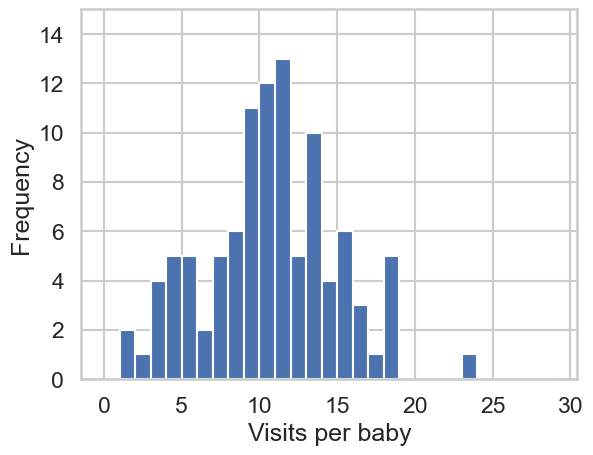

In [6]:
visits_per_baby = visits.groupby('BabyN').size()
_ = visits_per_baby.plot(kind='hist', bins=range(0, 30, 1))
_ = plt.xlabel('Visits per baby')
_ = plt.ylim(0, 15)

In [7]:
print("Median visits per baby:", visits_per_baby.median())
print("Max visits per baby:", visits_per_baby.max())

Median visits per baby: 10.0
Max visits per baby: 23


In [8]:
abx_usage = pd.read_csv('../data/metadata/antibiotic_usage.tsv', sep='\t', index_col=0)
abx_usage['Duration_(days)'] = pd.to_numeric(abx_usage['Duration_(days)'], errors='coerce')
abx_usage['Start_Date'] = pd.to_datetime(abx_usage['Start_Date'], errors='coerce')
abx_usage['Age_at_start'] = [(row['Start_Date'] - participants.loc[row['BabyN'], 'Date of Birth']).days for i, row in abx_usage.iterrows()]
abx_usage.head()

,BabyN,AntibioticN,Name,Reason,Start_Date,End_Date,Duration_(days),DateOfBirth,AgeAtStart,AgeAtEnd,Route,Age_at_start
PrimaryKey,,,,,,,,,,,,
Baby134_Antibiotic1,Baby134,1,piperacillin/ tazobactam,R/O sepsis,2018-11-26,2018-11-28,2.0,2018-11-22,4.0,6.0,IV,4.0
Baby134_Antibiotic2,Baby134,2,ampicillin,R/O sepsis,2018-11-26,2018-11-27,1.0,2018-11-22,4.0,5.0,IV,4.0
Baby134_Antibiotic3,Baby134,3,gentamicin,R/O sepsis,2018-11-26,2018-11-27,1.0,2018-11-22,4.0,5.0,IV,4.0
Baby134_Antibiotic4,Baby134,4,vancomycin,R/O sepsis,2018-11-26,2018-11-27,1.0,2018-11-22,4.0,5.0,IV,4.0
Baby235_Antibiotic1,Baby235,1,unknown anitbiotic(s),"R/O sepsis, later confirmed neg.",2018-06-19,Not Documented,NaN,2018-06-13,6.0,NaN,NaN,6.0


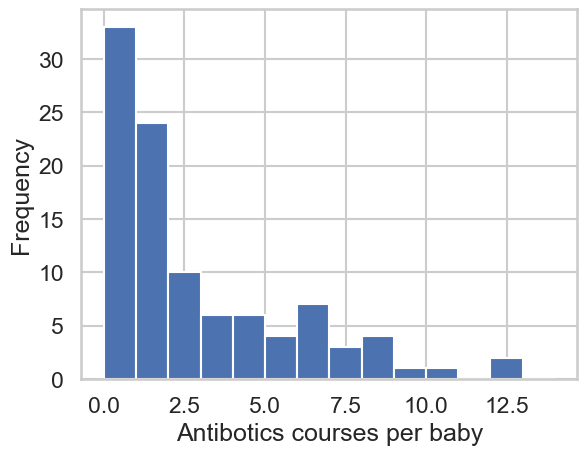

In [9]:
abx_courses_per_baby_no_zeroes = abx_usage.groupby('BabyN').size()
babies_wo_abx = set(visits_per_baby.index) - set(abx_courses_per_baby_no_zeroes.index)
abx_courses_per_baby = pd.concat([abx_courses_per_baby_no_zeroes, pd.Series({baby: 0 for baby in babies_wo_abx})])
_ = abx_courses_per_baby.plot(kind='hist', bins=range(0, 15, 1))
_ = plt.xlabel('Antibotics courses per baby')

In [10]:
print("Babies who never took abx:", (abx_courses_per_baby == 0).sum())
print("Median courses of abx per baby:", abx_courses_per_baby.median())
print("Max courses of abx per baby:", abx_courses_per_baby.max())

Babies who never took abx: 33
Median courses of abx per baby: 1.0
Max courses of abx per baby: 12


In [11]:
print("Abx used in first week of life:", abx_usage.query("Age_at_start < 7").groupby('BabyN').ngroups)
print("Abx used in first year of life:", abx_usage.query("Age_at_start < 365").groupby('BabyN').ngroups)
print("Abx used ever:", abx_usage.groupby('BabyN').ngroups)

Abx used in first week of life: 4
Abx used in first year of life: 57
Abx used ever: 68


In [12]:
abx_usage.query("Age_at_start < 7")

,BabyN,AntibioticN,Name,Reason,Start_Date,End_Date,Duration_(days),DateOfBirth,AgeAtStart,AgeAtEnd,Route,Age_at_start
PrimaryKey,,,,,,,,,,,,
Baby134_Antibiotic1,Baby134,1,piperacillin/ tazobactam,R/O sepsis,2018-11-26,2018-11-28,2.0,2018-11-22,4.0,6.0,IV,4.0
Baby134_Antibiotic2,Baby134,2,ampicillin,R/O sepsis,2018-11-26,2018-11-27,1.0,2018-11-22,4.0,5.0,IV,4.0
Baby134_Antibiotic3,Baby134,3,gentamicin,R/O sepsis,2018-11-26,2018-11-27,1.0,2018-11-22,4.0,5.0,IV,4.0
Baby134_Antibiotic4,Baby134,4,vancomycin,R/O sepsis,2018-11-26,2018-11-27,1.0,2018-11-22,4.0,5.0,IV,4.0
Baby235_Antibiotic1,Baby235,1,unknown anitbiotic(s),"R/O sepsis, later confirmed neg.",2018-06-19,Not Documented,NaN,2018-06-13,6.0,NaN,NaN,6.0
Baby245_Antibiotic1,Baby245,1,ampicillin,"respiratory issues, R/O sepsis at birth",2018-07-23,2018-07-26,3.0,2018-07-22,1.0,4.0,IV,1.0
Baby245_Antibiotic2,Baby245,2,gentamicin,"respiratory issues, R/O sepsis at birth",2018-07-23,2018-07-26,3.0,2018-07-22,1.0,4.0,IV,1.0
Baby246_Antibiotic1,Baby246,1,ampicillin,maternal chorioamnionitis,2018-07-28,2018-07-31,3.0,2018-07-28,0.0,3.0,IV,0.0


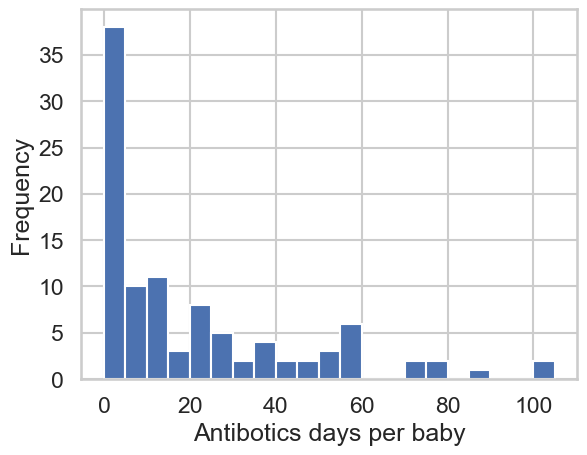

In [13]:
abx_days_per_baby_no_zeroes = abx_usage.groupby('BabyN')['Duration_(days)'].sum()
abx_days_per_baby = pd.concat([abx_days_per_baby_no_zeroes, pd.Series({baby: 0 for baby in babies_wo_abx})])
_ = abx_days_per_baby.plot(kind='hist', bins=range(0, 110, 5))
_ = plt.xlabel('Antibotics days per baby')

In [14]:
print("Median days of abx per baby:", abx_days_per_baby.median())
print("Max days of abx per baby:", abx_days_per_baby.max())

Median days of abx per baby: 10.0
Max days of abx per baby: 105.0


In [15]:
year_one_titers = pd.read_csv('../data/vaccine_response/vaccine_response_y1.tsv', sep='\t')
year_one_titers.head()

,BabyN,PT,Dip,FHA,PRN,TET,PRP (Hib),PCV ST1,PCV ST3,PCV ST4,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
0,Baby106,2.5,0.21,11.0,2.5,0.30,0.39,141.0,35.0,56.0,...,0.061955,0.052874,0.061955,False,True,True,False,True,True,NVR
1,Baby107,2.5,0.44,3.0,9.0,0.52,1.60,2430.0,415.0,194.0,...,0.449483,0.114018,0.958142,False,True,False,True,True,True,NVR
2,Baby108,2.5,0.05,1.5,2.5,0.05,0.27,21.0,3.0,24.0,...,0.000000,0.000000,0.003102,False,False,False,False,False,True,LVR
3,Baby109,27.0,NaN,NaN,63.0,1.35,7.02,NaN,NaN,NaN,...,0.700925,0.763049,0.486810,True,False,False,True,True,True,NVR
4,Baby110,14.0,0.24,15.0,20.0,2.45,NaN,301.0,63.0,400.0,...,0.266219,0.284211,0.245121,True,True,True,True,True,False,NVR


In [16]:
year_two_titers = pd.read_csv('../data/vaccine_response/vaccine_response_y2.tsv', sep='\t')
year_two_titers.head()

,BabyN,PT,Dip,FHA,PRN,TET,PRP (Hib),PCV ST1,PCV ST3,PCV ST4,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
0,Baby103,47.0,1.54,186.0,326.0,3.60,6.18,111.189953,46.960230,79.307349,...,0.190854,0.326317,0.146465,True,True,True,True,True,True,NVR
1,Baby108,31.0,1.21,34.0,43.0,2.12,4.15,36.929565,31.828768,82.189284,...,0.168430,0.172291,0.164958,True,True,True,True,True,True,NVR
2,Baby110,37.0,0.62,15.0,85.0,3.45,13.16,85.710344,58.493770,135.699571,...,0.298568,0.237230,0.358166,True,True,True,True,True,True,NVR
3,Baby112,11.0,0.23,22.0,68.0,0.79,14.69,118.861585,48.999537,92.404780,...,0.358315,0.085661,0.468588,True,True,True,True,True,True,NVR
4,Baby113,146.0,0.38,37.0,137.0,2.70,18.61,56.092263,17.140494,82.645151,...,0.221124,0.298591,0.221124,True,True,True,True,True,True,NVR


In [17]:
print("Number of babies with year 1 titers:", len(year_one_titers.index))
print("Number of babies with year 2 titers:", len(year_two_titers.index))

Number of babies with year 1 titers: 72
Number of babies with year 2 titers: 56


In [18]:
print("Number of babies with year 1 titers for DTapHib and NOT PCV:", pd.isna(year_one_titers['median_mmNorm_PCV']).sum())
print("Number of babies with year 2 titers for DTapHib and NOT PCV:", (pd.isna(year_two_titers[[i for i in year_two_titers.columns
                                                                                                if i.startswith('PCV')]]).sum(axis=1) > (12 * .75)).sum())

Number of babies with year 1 titers for DTapHib and NOT PCV: 5
Number of babies with year 2 titers for DTapHib and NOT PCV: 1


## Metabolomics sample numbers

In [19]:
metab_data = pd.read_excel('../data/metabolomics_abunds.xlsx', index_col=0).fillna(0)
metab_data[metab_data < 0] = 0
metab_data.head()

,GCDCA,GDCA,GHDCA or GUDCA,CA,TCDCA,TCA,CDCA,7oxoCA,TUDCA,UDCA or HDCA,...,Uracil,Adenosine,Phenaceturic acid,N-Acetyl D-galactosamine,Pyridoxal hydrochloride,2-Deoxyuridine,Vanillic acid,Thymine,Nicotinic acid,Homocitrate
Compound name,,,,,,,,,,,,,,,,,,,,,
P103_V12_05052020,13165.576990,6486.205847,1037.427698,877.477368,842.441112,428.399288,412.663454,6.309238,26.103778,37.617317,...,571,112,45,90,426,1223,6865,549,217,3044
P106_V9_04022019,5324.081005,615.267690,1431.812977,536.910350,477.807838,761.254736,55.773899,4.142229,91.815489,19.861706,...,400,368,206,217,201,372,53,230,216,109
P107_A1_04152019,11967.195030,3.048386,8876.579286,884.309058,2720.613568,3492.197205,106.185518,7.807234,664.956760,113.460800,...,594,112,8,330,102,9,87,55,177,6952
P108_V9_04022019,117.128627,0.000000,116.125243,29.790592,6.916959,5.775257,1.574994,0.418815,1.671431,4.996911,...,60,226,11,16,249,104,64,18,24,36
P108_V12_05212020,16651.224940,1707.969274,3575.590198,1277.281488,2356.663104,1109.351448,204.781749,41.696046,216.707453,107.961759,...,375,184,205,141,253,702,298,196,196,3468


In [20]:
metab_meta = pd.DataFrame([[i, int(i.split('_')[0].strip('P')), i.split('_')[1], i.split('_')[-1]]
                            for i in metab_data.index],
                          columns=['SampleID', 'BabyN', 'VisitCode', 'VisitDate']).set_index('SampleID')
metab_meta.head()

,BabyN,VisitCode,VisitDate
SampleID,,,
P103_V12_05052020,103,V12,05052020
P106_V9_04022019,106,V9,04022019
P107_A1_04152019,107,A1,04152019
P108_V9_04022019,108,V9,04022019
P108_V12_05212020,108,V12,05212020


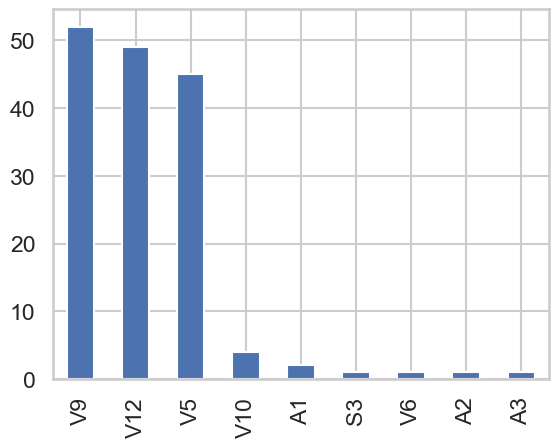

In [21]:
metab_samples_per_baby = metab_meta['VisitCode'].value_counts()
_ = metab_samples_per_baby.plot(kind='bar')

We could probably consolidate some of this by merging samples that could have been labelled based on an adjacent timepoint (i.e. sample at the V5/V6 border could be called V5 or a sick visit is called A2 but is at the V9 timepoint could be called V9).

In [22]:
print("Plasma metab samples at 2 months:", metab_samples_per_baby['V5'])
print("Plasma metab samples at 1 year:", metab_samples_per_baby['V9'])
print("Plasma metab samples at 2 years:", metab_samples_per_baby['V12'])

Plasma metab samples at 2 months: 45
Plasma metab samples at 1 year: 52
Plasma metab samples at 2 years: 49


## Proteomics sample numbers

In [23]:
proteo_data = pd.read_csv('../data/proteomics_abunds.txt', sep='\t', index_col=0).transpose()
proteo_data.head()

,BioID,Well,Run Number,Hospital,VisitID,Age,Draw,Matrix,Draw_Matrix,Draw_Matrix_Time,...,sp|Q6UWP8|SBSN_HUMAN,sp|Q6UXB8|PI16_HUMAN,sp|Q92736|RYR2_HUMAN,sp|Q96IY4|CBPB2_HUMAN,sp|Q96PD5|PGRP2_HUMAN,sp|Q9HDC9|APMAP_HUMAN,sp|Q9NZP8|C1RL_HUMAN,sp|Q9UBP9|GULP1_HUMAN,sp|Q9UGM5|FETUB_HUMAN,sp|Q9Y490|TLN1_HUMAN
LFQ intensity 005_HFX_HW_RAW_IMC_A1_106A,106A,A1,5,Well Check 02m,V5,63,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,18.2125721,23.48308372,20.45380974,21.819561,25.08229065,20.85553551,20.4588604,28.83514977,21.02322769,20.34404564
LFQ intensity 006_HFX_HW_RAW_IMC_A2_209A,209A,A2,6,Well Check 02m,V5,55,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,16.90970612,23.31561852,18.60210037,22.21127701,24.88887978,20.59141159,17.14304733,28.68237686,21.82271576,19.7013855
LFQ intensity 012_HFX_HW_RAW_IMC_A8_214A,214A,A8,12,Well Check 02m,V5,89,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,13.34554386,23.58817863,18.65951729,21.8640461,25.16353798,21.04162788,18.74650764,29.10836601,19.95448685,20.4085598
LFQ intensity 021_HFX_HW_RAW_IMC_C3_227A,227A,C3,21,Well Check 02m,V5,57,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,20.80704689,23.25824928,21.18655968,21.24667168,25.07989311,19.46746445,20.6216526,28.35871315,20.65556526,20.66396141
LFQ intensity 024_HFX_HW_RAW_IMC_C6_124A,124A,C6,24,Well Check 02m,V5,97,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,17.50129318,23.05339622,21.60560417,21.72242355,25.20258331,19.91134644,21.13340378,28.25678444,20.77088356,20.50154495


In [24]:
proteo_meta = proteo_data.loc[[i for i in proteo_data.index if i.startswith('LFQ intensity')],
                               proteo_data.columns[:list(proteo_data.columns).index('Subject ID')+1]]
proteo_meta.index = [i.split()[-1] for i in proteo_meta.index]
column_name_replacements = {'Subject ID': 'BabyN', 'VisitID': 'VisitCode'}
proteo_meta.columns = [i if i not in column_name_replacements else column_name_replacements[i] for i in proteo_meta.columns]
proteo_meta['BabyN'] = [int(i) for i in proteo_meta['BabyN']]
proteo_meta.head()

,BioID,Well,Run Number,Hospital,VisitCode,Age,Draw,Matrix,Draw_Matrix,Draw_Matrix_Time,Plate,Responder Status,Group_ID,Group_ID_Responder,Responder Status NVRHVR,Group_ID_Responder2Groups,BabyN
005_HFX_HW_RAW_IMC_A1_106A,106A,A1,5,Well Check 02m,V5,63,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,1,LVR,V5_Heelstick_Serum_LVR,V5_Heelstick_Serum_LVR,NVR,V5_Heelstick_Serum_NVR,106
006_HFX_HW_RAW_IMC_A2_209A,209A,A2,6,Well Check 02m,V5,55,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,1,NVR,V5_Heelstick_Serum_NVR,V5_Heelstick_Serum_NVR,NVR,V5_Heelstick_Serum_NVR,209
012_HFX_HW_RAW_IMC_A8_214A,214A,A8,12,Well Check 02m,V5,89,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,1,HVR,V5_Heelstick_Serum_HVR,V5_Heelstick_Serum_HVR,HVR,V5_Heelstick_Serum_HVR,214
021_HFX_HW_RAW_IMC_C3_227A,227A,C3,21,Well Check 02m,V5,57,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,1,HVR,V5_Heelstick_Serum_HVR,V5_Heelstick_Serum_HVR,HVR,V5_Heelstick_Serum_HVR,226
024_HFX_HW_RAW_IMC_C6_124A,124A,C6,24,Well Check 02m,V5,97,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,1,NaN,V5_Heelstick_Serum_NA,V5_Heelstick_Serum_NA,NaN,V5_Heelstick_Serum_NA,124


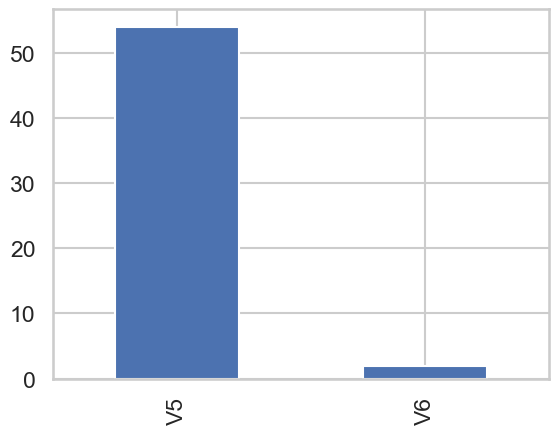

In [25]:
proteo_samples_per_baby = proteo_meta['VisitCode'].value_counts()
_ = proteo_samples_per_baby.plot(kind='bar')

In [26]:
print("Plasma proteome samples at 2 months:", proteo_samples_per_baby['V5'])

Plasma proteome samples at 2 months: 54


## Stool sample numbers

In [27]:
stool_metadata = pd.read_csv('../data/metadata/stool/stool_metadata.csv', index_col=0)
stool_metadata.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,VisitCodeTimeEquivalent,VisitCode_or_TimeEquivalent_checked,OutputFileName,Plate,Row,Column,age_at_collection,collection_method,Count,gt_2.5
SampleID,,,,,,,,,,,,,,,,,,,,,
204_V5,Primary in Tube,1,NaN,204_S,"Box 7, A1",Stool,Human Infant,MetaG,204,NaN,...,2 months,NaN,204_V5,3,3,8,67.0,Home,3628514,True
226_V1,Primary in Tube,2,NaN,NaN,"Box 7, A2",Stool,Human Infant,MetaG,226,NaN,...,1-6 days,NaN,226_V1,5,5,2,4.0,Clinic,3363490,True
107_V3,Primary in Tube,3,NaN,NaN,"Box 7, A3",Stool,Human Infant,MetaG,107,NaN,...,2 weeks,NaN,107_V3,7,3,7,18.0,Home,3350273,True
108_V3,Primary in Tube,4,NaN,NaN,"Box 7, A4",Stool,Human Infant,MetaG,108,NaN,...,2 weeks,NaN,108_V3,3,1,1,16.0,Home,5095831,True
109_V1,Primary in Tube,5,NaN,NaN,"Box 7, A5",Stool,Human Infant,MetaG,109,NaN,...,1-6 days,NaN,109_V1,6,6,12,3.0,Home,4963525,True


In [28]:
len(stool_metadata)

709

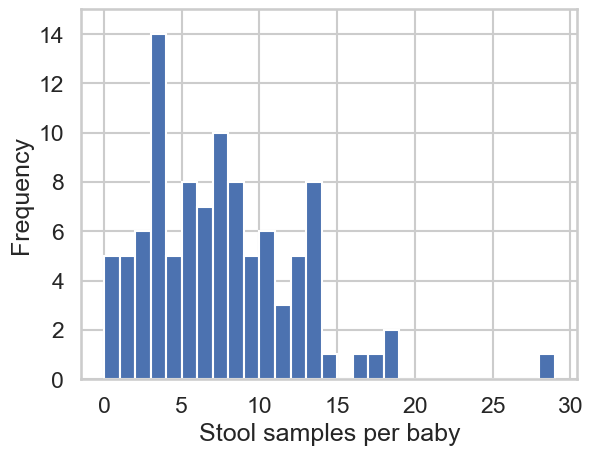

In [29]:
stool_per_baby_no_zeroes = stool_metadata.groupby('BabyN').size()
stool_per_baby_no_zeroes.index = ['Baby%s' % babyn for babyn in stool_per_baby_no_zeroes.index]
babies_wo_stool = set(visits_per_baby.index) - set(stool_per_baby_no_zeroes.index)
stool_per_baby = pd.concat([stool_per_baby_no_zeroes, pd.Series({baby: 0 for baby in babies_wo_stool})])
_ = stool_per_baby.plot(kind='hist', bins=range(0, 30, 1))
_ = plt.xlabel('Stool samples per baby')
_ = plt.ylim(0, 15)

In [30]:
print("Babies who never gave stool:", (stool_per_baby == 0).sum())
print("Median stool samples per baby:", stool_per_baby.median())
print("Max stool samples per baby:", stool_per_baby.max())

Babies who never gave stool: 5
Median stool samples per baby: 7.0
Max stool samples per baby: 29


## Nasal sample numbers

In [31]:
nasal_metadata = pd.read_csv('../data/metadata/nasal/nasal_metadata.csv', index_col=0)
nasal_metadata.head()

,SampleNumber,SampleID,SampleIDValidation,DiversigenCheckInSampleName,ReplacesLowVolumeSampleID,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,...,DOB_checked,CollectionDate,CollectionDate_checked,VisitCode,VisitCode_checked,SwabCode,OutputFileName,Plate,Row,Column
SubmissionType,,,,,,,,,,,,,,,,,,,,,
Primary in Tube,1,103_V5_NS_A1,NaN,NaN,NaN,"Box 1, A1",Nasal Swab,Human Infant,16S,103,...,NaN,2018-04-27,NaN,V5,NaN,A1,103_V5_NS_A1,4,6,12
Primary in Tube,2,106_V5_NS_A1,NaN,NaN,NaN,"Box 1, A3",Nasal Swab,Human Infant,16S,106,...,NaN,2018-05-29,NaN,V5,NaN,A1,106_V5_NS_A1,8,3,4
Primary in Tube,3,107_V2_NS_A1,NaN,NaN,NaN,"Box 1, A4",Nasal Swab,Human Infant,16S,107,...,NaN,2018-04-09,NaN,V2,NaN,A1,107_V2_NS_A1,11,2,2
Primary in Tube,4,107_V3_NS_A1,NaN,107_V8_NS_A1,NaN,"Box 1, A5",Nasal Swab,Human Infant,16S,107,...,NaN,2018-04-20,NaN,V3,NaN,A1,107_V3_NS_A1,11,2,3
Primary in Tube,5,107_V5_NS_A1,NaN,NaN,NaN,"Box 1, A8",Nasal Swab,Human Infant,16S,107,...,NaN,2018-06-04,NaN,V5,NaN,A1,107_V5_NS_A1,11,2,4


In [32]:
len(nasal_metadata)

1008

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_15892/1572658992.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  nasal_per_baby = pd.concat([nasal_per_baby_no_zeroes, pd.Series({baby: 0 for baby in babies_wo_nasal})])


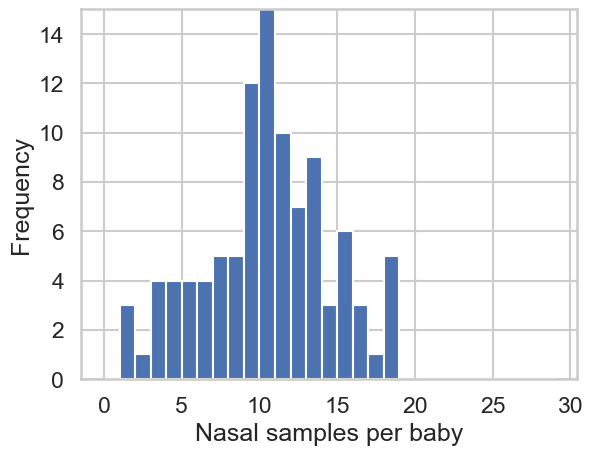

In [33]:
nasal_per_baby_no_zeroes = nasal_metadata.groupby('BabyN').size()
nasal_per_baby_no_zeroes.index = ['Baby%s' % babyn for babyn in nasal_per_baby_no_zeroes.index]
babies_wo_nasal = set(visits_per_baby.index) - set(nasal_per_baby_no_zeroes.index)
nasal_per_baby = pd.concat([nasal_per_baby_no_zeroes, pd.Series({baby: 0 for baby in babies_wo_nasal})])
_ = nasal_per_baby.plot(kind='hist', bins=range(0, 30, 1))
_ = plt.xlabel('Nasal samples per baby')
_ = plt.ylim(0, 15)

In [34]:
print("Babies who never gave nasal:", (nasal_per_baby == 0).sum())
print("Median nasal samples per baby:", nasal_per_baby.median())
print("Max nasal samples per baby:", nasal_per_baby.max())

Babies who never gave nasal: 0
Median nasal samples per baby: 10.0
Max nasal samples per baby: 18
